<a href="https://colab.research.google.com/github/vagdevi17/Speech-Emotion-Recognition/blob/main/Copy_of_Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing Libraries**

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import regularizers
import os
import glob
import pandas as pd
import IPython.display as ipd
import plotly.express as px
import scipy.io.wavfile
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

**Preprocessing**

In [ ]:
RAV = '/content/drive/MyDrive/archive (1)/audio_speech_actors_01-24/'
dir_list = os.listdir(RAV)

emotion = []
gender = []
path = []
feature = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)
        RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender'], axis=1)
RAV_df.labels.value_counts()

,count
labels,
male_neutral,144
female_neutral,144
male_surprise,96
male_disgust,96
male_fear,96
male_angry,96
male_sad,96
male_happy,96
female_disgust,96


In [ ]:
display(RAV_df.head())
display(RAV_df.describe())

,emotion,labels,source,path
0,surprise,male_surprise,RAVDESS,/content/drive/MyDrive/archive (1)/audio_speec...
1,surprise,male_surprise,RAVDESS,/content/drive/MyDrive/archive (1)/audio_speec...
2,disgust,male_disgust,RAVDESS,/content/drive/MyDrive/archive (1)/audio_speec...
3,disgust,male_disgust,RAVDESS,/content/drive/MyDrive/archive (1)/audio_speec...
4,disgust,male_disgust,RAVDESS,/content/drive/MyDrive/archive (1)/audio_speec...


,emotion,labels,source,path
count,1440,1440,1440,1440
unique,7,14,1,1440
top,neutral,male_neutral,RAVDESS,/content/drive/MyDrive/archive (1)/audio_speec...
freq,288,144,1440,1


**Data Visualization**

In [ ]:
px_fig = px.histogram(RAV_df, x='emotion', color='emotion', marginal='box',
                      title='Emotion Count')
px_fig.update_layout(bargap=0.2)
px_fig.show()

px_fig = px.histogram(RAV_df, x='labels', color='emotion', marginal='box',
                      title='Label Count')
px_fig.update_layout(bargap=0.2)
px_fig.show()

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

In [ ]:
def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

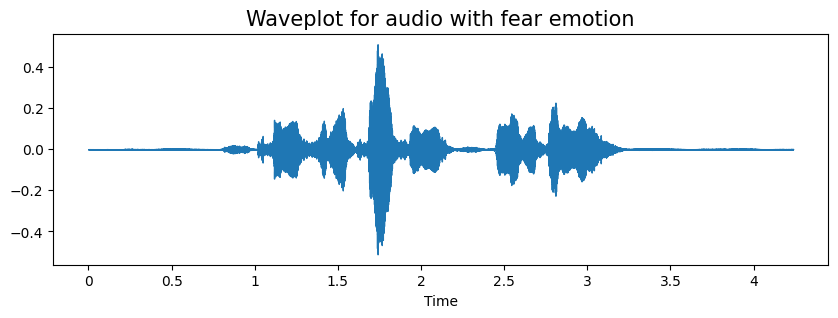

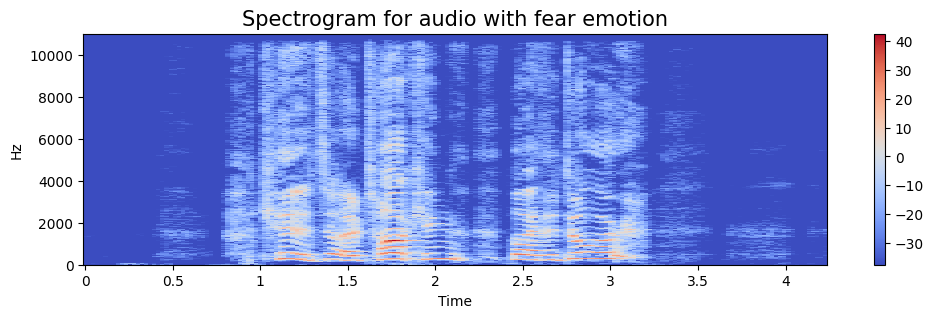

In [ ]:
emotion='fear'
path = np.array(RAV_df.path[RAV_df.emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
ipd.Audio(path)

**Data Augmentation**

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate = rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(RAV_df.path)[1]
data, sample_rate = librosa.load(path)

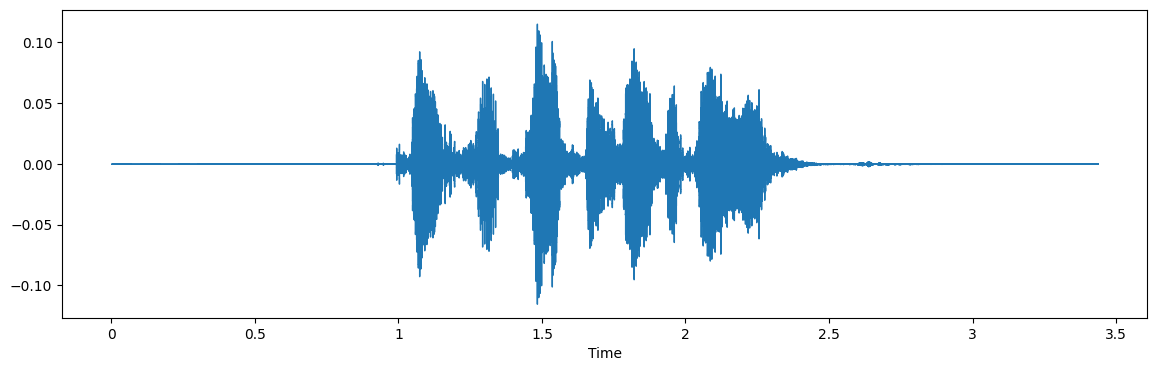

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
ipd.Audio(path)

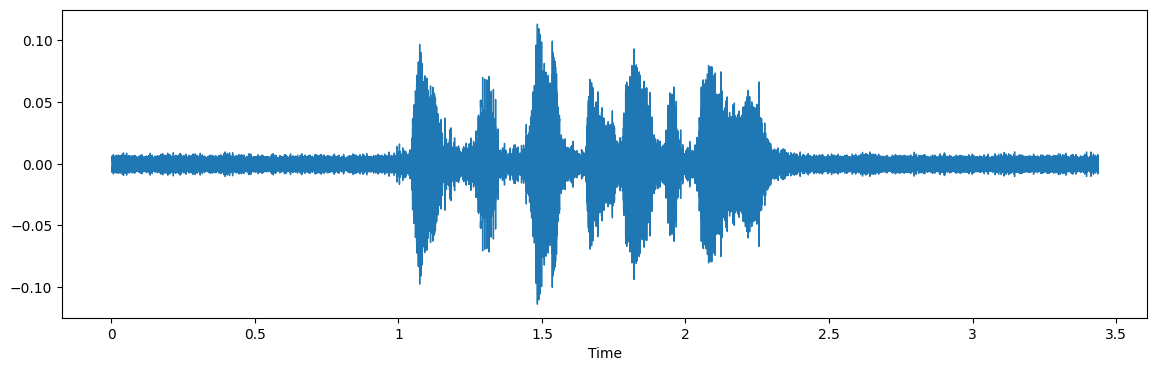

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

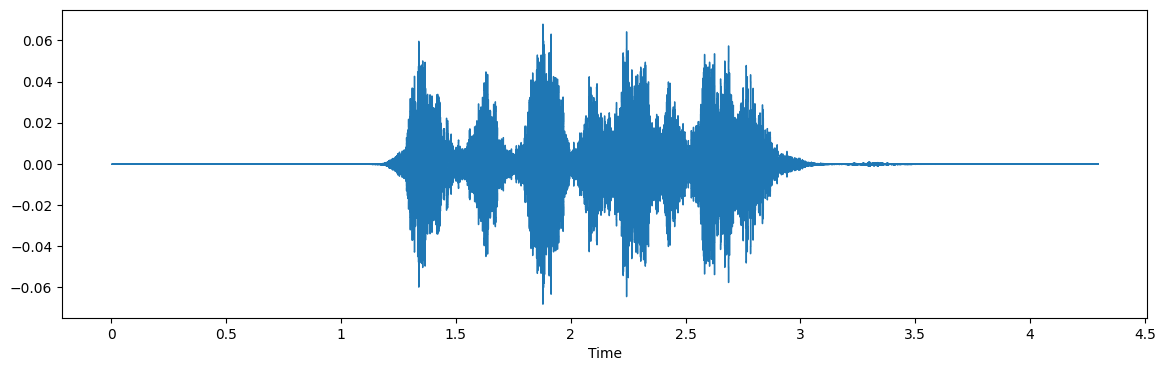

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

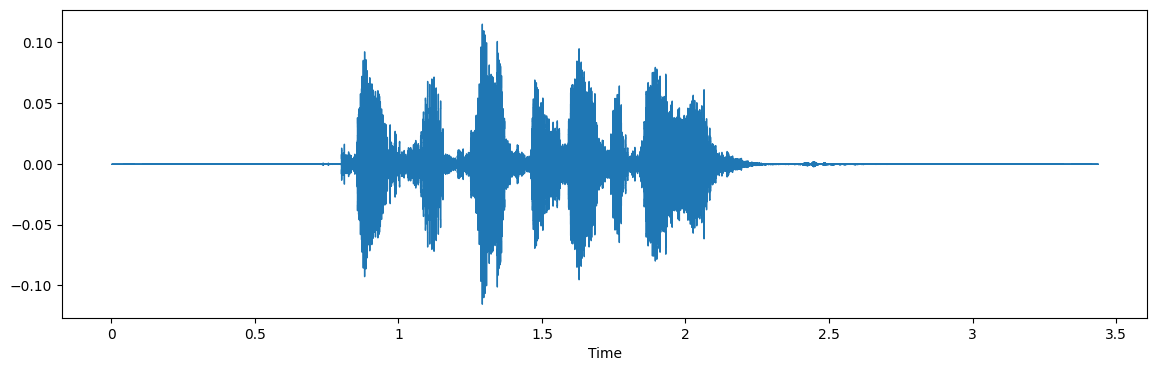

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

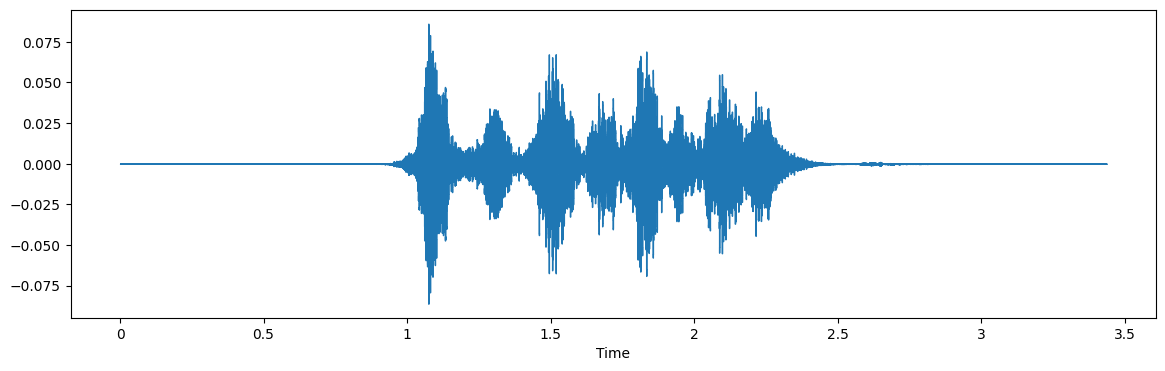

In [ ]:
x = pitch(data,sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

**Feature Extraction :**

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [ ]:
print(len(RAV_df.path))

1440


**Data Preperation**

In [ ]:
import tqdm
X, Y = [], []
for path, emotion in tqdm.tqdm(zip(RAV_df.path, RAV_df.emotion),total=len(RAV_df.path)):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

100%|██████████| 1440/1440 [12:36<00:00,  1.90it/s]


In [ ]:
len(X), len(Y), RAV_df.path.shape

(4320, 4320, (1440,))

In [ ]:



Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)

In [ ]:
display(Features.head())
display(Features.describe())

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.314865,0.692460,0.791060,0.822028,0.752273,0.696571,0.619070,0.634238,0.699437,0.675584,...,0.000071,0.000064,0.000038,0.000050,0.000137,0.000093,0.000063,0.000043,2.550499e-06,surprise
1,0.312627,0.759486,0.838223,0.852063,0.811724,0.777598,0.695650,0.675303,0.705803,0.691571,...,0.000157,0.000146,0.000116,0.000131,0.000214,0.000173,0.000157,0.000133,8.757850e-05,surprise
2,0.212826,0.708777,0.801225,0.780171,0.721470,0.653534,0.608269,0.665053,0.677505,0.639560,...,0.000009,0.000009,0.000015,0.000011,0.000012,0.000020,0.000029,0.000010,8.723620e-07,surprise
3,0.251121,0.649801,0.689257,0.702635,0.713152,0.692802,0.660883,0.639581,0.691741,0.718707,...,0.000046,0.000048,0.000038,0.000027,0.000028,0.000044,0.000052,0.000037,3.093576e-06,surprise
4,0.216901,0.669377,0.717544,0.728711,0.728639,0.722464,0.688091,0.635697,0.662512,0.715162,...,0.000047,0.000048,0.000038,0.000027,0.000028,0.000044,0.000052,0.000037,3.342977e-06,surprise


,0,1,2,3,4,5,6,7,8,9,...,152,153,154,155,156,157,158,159,160,161
count,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,...,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03
mean,0.210647,0.627934,0.631326,0.636317,0.646097,0.635159,0.606498,0.601236,0.620030,0.637235,...,1.695340e-03,1.708117e-03,1.752058e-03,1.786444e-03,1.833290e-03,1.869412e-03,1.869988e-03,1.827893e-03,1.330820e-03,6.993341e-04
std,0.068667,0.087993,0.097545,0.100378,0.102054,0.104406,0.091273,0.078525,0.080532,0.079272,...,5.735544e-03,5.718836e-03,5.954904e-03,6.182153e-03,6.416933e-03,6.460895e-03,6.303854e-03,5.984942e-03,4.901521e-03,3.947972e-03
min,0.060091,0.339261,0.287325,0.274444,0.261164,0.263645,0.269483,0.262952,0.242572,0.269638,...,2.135293e-08,1.692828e-08,2.129181e-08,2.400353e-08,2.899570e-08,2.325147e-08,6.041341e-08,7.742907e-08,3.496952e-08,2.159540e-09
25%,0.154885,0.568382,0.564533,0.566360,0.576462,0.565799,0.550477,0.554268,0.569520,0.586670,...,2.953069e-05,2.960734e-05,3.048899e-05,3.203296e-05,3.452954e-05,3.462461e-05,3.493535e-05,3.404599e-05,2.053893e-05,2.025238e-06
50%,0.201454,0.631359,0.636480,0.641643,0.653223,0.642162,0.615973,0.609971,0.625569,0.643496,...,1.689202e-04,1.694548e-04,1.694766e-04,1.807261e-04,1.869922e-04,1.824085e-04,1.859934e-04,1.812662e-04,1.134804e-04,1.473595e-05
75%,0.267279,0.692683,0.701853,0.711794,0.721507,0.708818,0.670281,0.656511,0.677874,0.692864,...,8.626809e-04,8.685183e-04,9.359833e-04,9.150948e-04,9.288893e-04,9.330402e-04,9.481783e-04,9.614564e-04,6.158465e-04,1.128459e-04
max,0.391412,0.861825,0.871637,0.905922,0.893489,0.904388,0.871814,0.813966,0.825857,0.868190,...,1.050221e-01,9.330363e-02,1.248635e-01,1.394238e-01,1.542256e-01,1.455012e-01,1.236555e-01,9.233339e-02,8.971948e-02,8.405979e-02


In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 7), (1080, 162), (1080, 7))

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 7), (1080, 162), (1080, 7))

In [ ]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 7), (1080, 162, 1), (1080, 7))

**Modelling**

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 162, 256)            │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 81, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 81, 128)             │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 41, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 41, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 21, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 21, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 21, 32)              │          10,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 11, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 352)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │           5,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             119 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 222,567 (869.40 KB)

 Trainable params: 222,567 (869.40 KB)

 Non-trainable params: 0 (0.00 B)

**Training**

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=4, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 244ms/step - accuracy: 0.1821 - loss: 1.9248 - val_accuracy: 0.2704 - val_loss: 1.8473 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 214ms/step - accuracy: 0.2573 - loss: 1.8222 - val_accuracy: 0.3120 - val_loss: 1.7780 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 237ms/step - accuracy: 0.2933 - loss: 1.7896 - val_accuracy: 0.3491 - val_loss: 1.7114 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 266ms/step - accuracy: 0.3185 - loss: 1.7323 - val_accuracy: 0.3806 - val_loss: 1.6896 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 236ms/step - accuracy: 0.3397 - loss: 1.6731 - val_accuracy: 0.3620 - val_loss: 1.6527 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 236ms/step - accuracy: 0.3554 - loss: 1.6470 - val_accuracy: 0.3926 - val_loss: 1.6080 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step - accuracy: 0.3643 - loss: 1.

**Evaluation**

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6104 - loss: 1.3561
Accuracy of our model on test data :  58.888888359069824 %


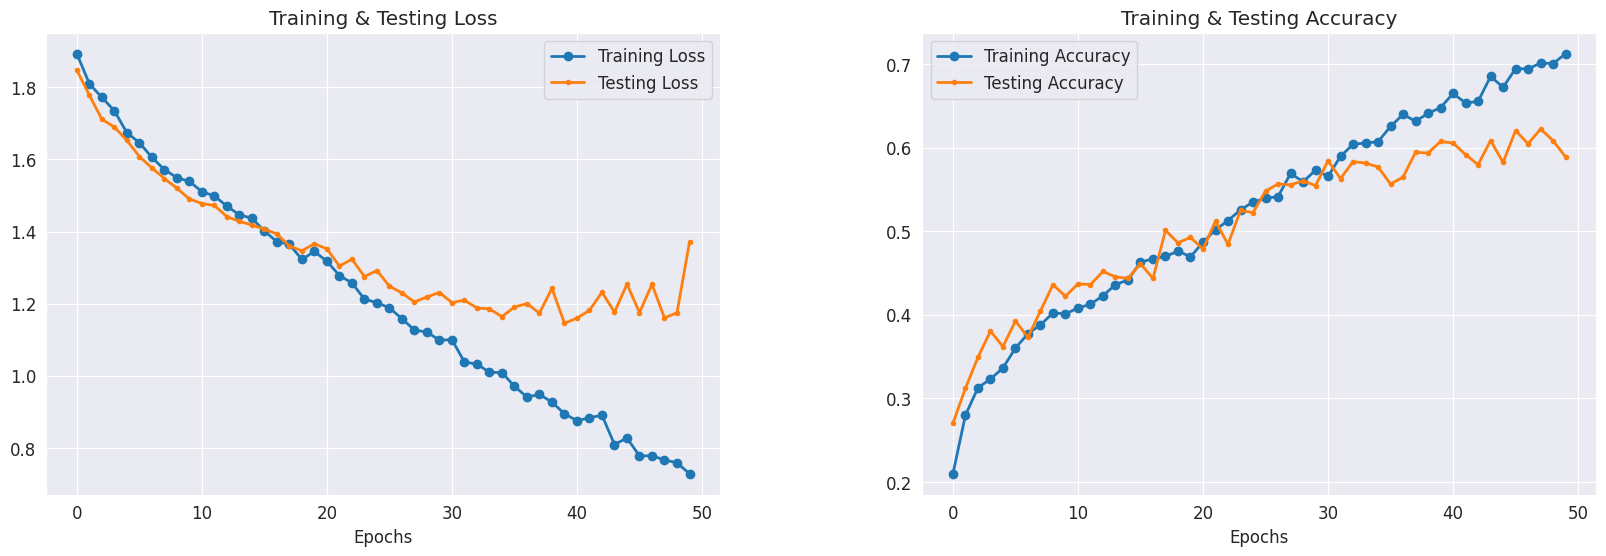

In [ ]:
!pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

# Use seaborn.set_style to apply the desired style
sns.set_style("darkgrid")  # Instead of plt.style.use('seaborn-darkgrid')

plt.rcParams.update({'font.size': 12})
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss',marker='o', linewidth=2)
ax[0].plot(epochs , test_loss , label = 'Testing Loss',marker='.', linewidth=2)
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy',marker='o', linewidth=2)
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy',marker='.', linewidth=2)
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.subplots_adjust(wspace=0.3)
plt.show()

In [ ]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

display(df.head())

,Predicted Labels,Actual Labels
0,fear,disgust
1,neutral,surprise
2,angry,angry
3,neutral,neutral
4,surprise,angry


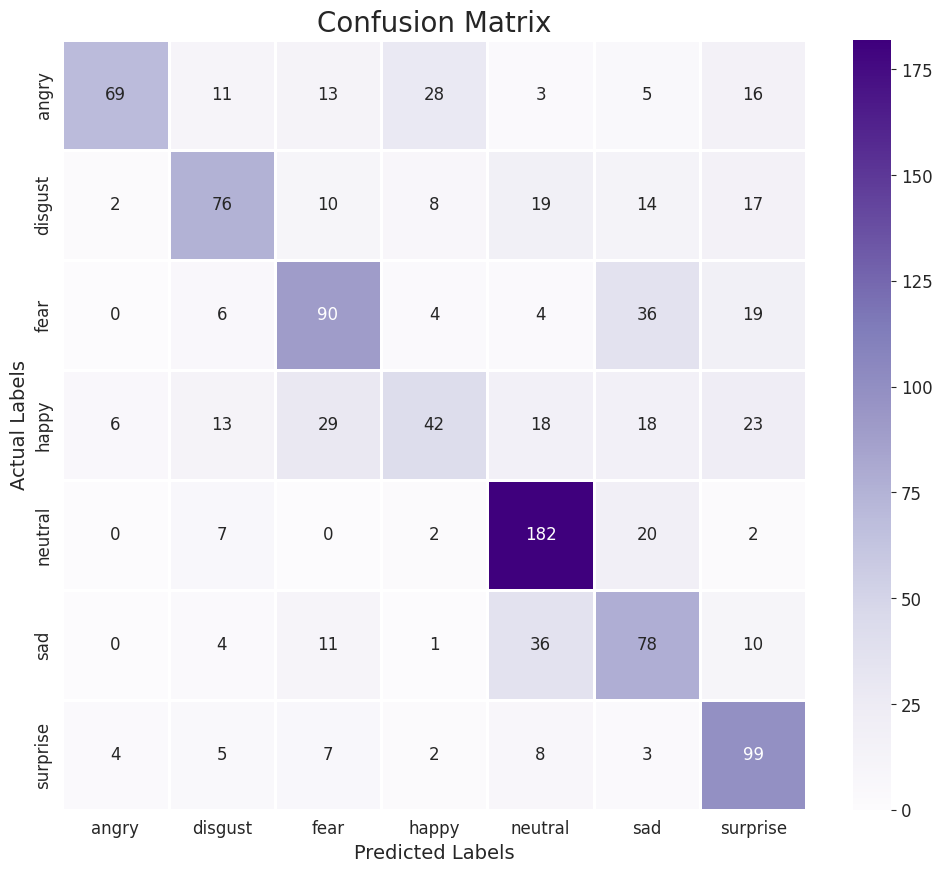

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Purples', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.85      0.48      0.61       145
     disgust       0.62      0.52      0.57       146
        fear       0.56      0.57      0.56       159
       happy       0.48      0.28      0.36       149
     neutral       0.67      0.85      0.75       213
         sad       0.45      0.56      0.50       140
    surprise       0.53      0.77      0.63       128

    accuracy                           0.59      1080
   macro avg       0.60      0.58      0.57      1080
weighted avg       0.60      0.59      0.58      1080



# **Live Demo**

The file '*.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

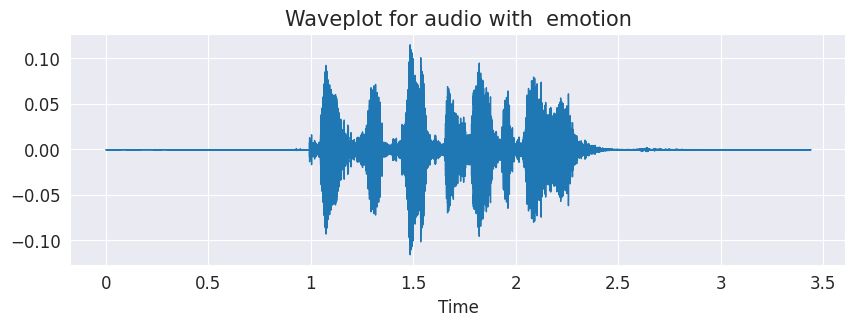

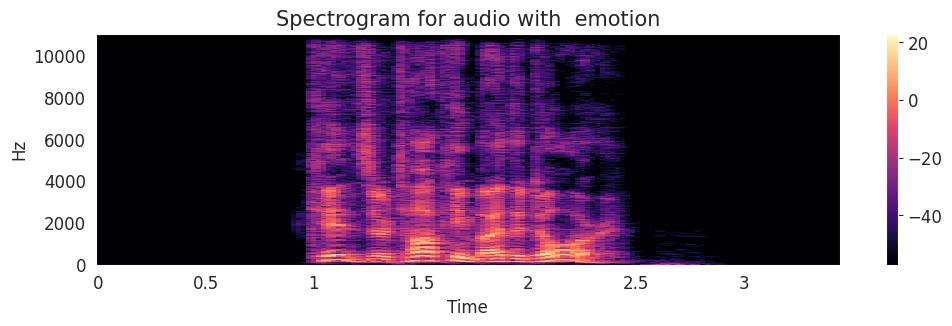

In [ ]:
path = '/content/drive/MyDrive/archive (1)/audio_speech_actors_01-24/Actor_02/03-01-01-01-01-01-02.wav'
# part = path.split("/")[-1].split('.')[0].split('-')
# emotion = {1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}[int(part[2])]
# data, sampling_rate = librosa.load(path)
emotion = ""
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
ipd.Audio(path)

In [ ]:
X_live, Y_live = [], []
feature = get_features(path)
for ele in feature:
    X_live.append(ele)
    # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
    Y_live.append(emotion)

In [ ]:
Features_live = pd.DataFrame(X_live)
x_live = scaler.transform(Features_live)
x_live = np.expand_dims(x_live, axis=2)
pred_live = model.predict(x_live)
y_pred_live = encoder.inverse_transform(pred_live)
print("Predicted emotion:", y_pred_live[0][0])
# print("Ground truth emotion:", emotion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted emotion: neutral
